### [1] 패키지 불러오기

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import torchvision.transforms as transforms
from PIL import Image

### [2] Data transform 정의

In [2]:
import torchvision.transforms as transforms

# 사이즈 설정
size = [230, 230]
center_size = [224, 224]

# 학습용 Transform
TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증/테스트용 Transform
ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### [3] 수정된 Eye dataset 클래스 (thickness 추가)

In [3]:
# CIMT thickness를 5개 구간으로 분류하는 함수
def thickness_to_label(thickness):
    if thickness < 0.7:
        return 0
    elif thickness < 0.9:
        return 1
    elif thickness < 1.1:
        return 2
    elif thickness < 1.3:
        return 3
    else:
        return 4


In [4]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset

class SingleModalEyeDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        left_img = Image.open(os.path.join(self.image_path, item['left_eye'])).convert('RGB')
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        label = torch.tensor(item['label'], dtype=torch.long)

        # 두께를 구간 분류 라벨로 변환
        thickness_label = thickness_to_label(item['thickness'])
        thickness_tensor = torch.tensor(thickness_label, dtype=torch.long)

        return left_img, right_img, label, thickness_tensor

    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, include_0_9mm=True, transform=None):
        with open(json_file, 'r') as f:
            raw_data = json.load(f)

        usable_data = [
            item for item in raw_data.values()
            if item['group'] == group_value and (include_0_9mm or item['thickness'] != 0.9)
        ]

        print(f"usable samples for group {group_value}: {len(usable_data)}")
        return cls(usable_data, image_path, transform)


### [4] 구글 드라이브 연동

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### [5] train_loader, val_loader, test_loader 구성

In [6]:
from torch.utils.data import DataLoader

# 경로 설정
json_path = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 데이터셋 생성
train_dataset = SingleModalEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=1, transform=TrainTransform)
val_dataset = SingleModalEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=2, transform=ValidTransform)
test_dataset = SingleModalEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=3, transform=ValidTransform)

# 최적화된 데이터로더
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


usable samples for group 1: 2603
usable samples for group 2: 200
usable samples for group 3: 100


### [6] SiameseSeResNeXtdropout 모델 정의

In [11]:
import torch
import torch.nn as nn
import timm

class SiameseEfficientNetV2MultiTask(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(SiameseEfficientNetV2MultiTask, self).__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(dropout_p)

        # 분류 헤드 (binary classification)
        self.classifier = nn.Sequential(
            nn.Linear(2560, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 2)
        )

        # 두께 구간 분류 헤드 (thickness interval classification)
        self.thick_classifier = nn.Sequential(
            nn.Linear(2560, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 5)
        )

    def forward(self, left, right):
        left_feat = self.backbone(left)
        right_feat = self.backbone(right)
        combined_feat = torch.cat([left_feat, right_feat], dim=1)
        combined_feat = self.dropout(combined_feat)

        class_out = self.classifier(combined_feat)
        thick_out = self.thick_classifier(combined_feat)

        return class_out, thick_out


### [7] FocalLoss 클래스 정의

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

### [8] 학습 루프

In [13]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler
import json

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 손실 함수 정의
criterion_cls = FocalLoss()
criterion_thick_cls = nn.CrossEntropyLoss()
lambda_thick = 1.0  # 두께 구간 분류 손실의 가중치

# 모델 초기화
model = SiameseEfficientNetV2MultiTask().to(device)

# 옵티마이저 (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# 스케줄러 설정
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 하이퍼파라미터 및 기록 변수
epochs = 20
best_val_loss = float('inf')
train_cls_losses, train_thick_losses, train_total_losses = [], [], []
val_cls_losses, val_thick_losses, val_total_losses = [], [], []

# 학습 루프 시작
for epoch in range(epochs):
    model.train()
    running_cls_loss, running_thick_loss, running_total_loss = 0.0, 0.0, 0.0

    for left, right, labels, thicknesses in train_loader:
        left, right = left.to(device), right.to(device)
        labels = labels.to(device)
        thicknesses = thicknesses.to(device)  # 구간 분류: long 타입

        optimizer.zero_grad()
        outputs_cls, outputs_thick = model(left, right)

        loss_cls = criterion_cls(outputs_cls, labels)
        loss_thick = criterion_thick_cls(outputs_thick, thicknesses)
        loss = loss_cls + lambda_thick * loss_thick

        loss.backward()
        optimizer.step()

        running_cls_loss += loss_cls.item()
        running_thick_loss += loss_thick.item()
        running_total_loss += loss.item()

    # 평균 손실 계산 (train)
    avg_train_cls = running_cls_loss / len(train_loader)
    avg_train_thick = running_thick_loss / len(train_loader)
    avg_train_total = running_total_loss / len(train_loader)

    train_cls_losses.append(avg_train_cls)
    train_thick_losses.append(avg_train_thick)
    train_total_losses.append(avg_train_total)

    # 검증 루프
    model.eval()
    val_cls_loss, val_thick_loss, val_total_loss = 0.0, 0.0, 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for left, right, labels, thicknesses in val_loader:
            left, right = left.to(device), right.to(device)
            labels = labels.to(device)
            thicknesses = thicknesses.to(device)

            outputs_cls, outputs_thick = model(left, right)

            loss_cls = criterion_cls(outputs_cls, labels)
            loss_thick = criterion_thick_cls(outputs_thick, thicknesses)
            loss = loss_cls + lambda_thick * loss_thick

            val_cls_loss += loss_cls.item()
            val_thick_loss += loss_thick.item()
            val_total_loss += loss.item()

            preds = torch.argmax(outputs_cls, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_cls = val_cls_loss / len(val_loader)
    avg_val_thick = val_thick_loss / len(val_loader)
    avg_val_total = val_total_loss / len(val_loader)
    val_accuracy = correct / total

    val_cls_losses.append(avg_val_cls)
    val_thick_losses.append(avg_val_thick)
    val_total_losses.append(avg_val_total)

    scheduler.step()

    # 베스트 모델 저장 (총 손실 기준)
    if avg_val_total < best_val_loss:
        best_val_loss = avg_val_total
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/01unimodal/best_multitask_classification2.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Total Loss: {best_val_loss:.4f})")

    # 에폭별 로그 출력
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train: [Cls: {avg_train_cls:.4f} | Thick: {avg_train_thick:.4f} | Total: {avg_train_total:.4f}] | "
          f"Val: [Cls: {avg_val_cls:.4f} | Thick: {avg_val_thick:.4f} | Total: {avg_val_total:.4f}] | "
          f"Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


Best model updated at epoch 1 (Val Total Loss: 1.3758)
Epoch 1/20 | Train: [Cls: 0.1310 | Thick: 1.2864 | Total: 1.4174] | Val: [Cls: 0.1421 | Thick: 1.2336 | Total: 1.3758] | Val Acc: 0.7600 | LR: 0.000100
Epoch 2/20 | Train: [Cls: 0.1195 | Thick: 1.1327 | Total: 1.2522] | Val: [Cls: 0.1687 | Thick: 1.3251 | Total: 1.4938] | Val Acc: 0.6600 | LR: 0.000100
Epoch 3/20 | Train: [Cls: 0.1155 | Thick: 1.1051 | Total: 1.2206] | Val: [Cls: 0.1477 | Thick: 1.2502 | Total: 1.3979] | Val Acc: 0.6900 | LR: 0.000100
Epoch 4/20 | Train: [Cls: 0.1105 | Thick: 1.0601 | Total: 1.1707] | Val: [Cls: 0.1526 | Thick: 1.2352 | Total: 1.3879] | Val Acc: 0.6950 | LR: 0.000100
Epoch 5/20 | Train: [Cls: 0.1067 | Thick: 1.0134 | Total: 1.1201] | Val: [Cls: 0.1594 | Thick: 1.3125 | Total: 1.4720] | Val Acc: 0.7050 | LR: 0.000100
Epoch 6/20 | Train: [Cls: 0.1010 | Thick: 0.9670 | Total: 1.0680] | Val: [Cls: 0.1507 | Thick: 1.3144 | Total: 1.4652] | Val Acc: 0.7500 | LR: 0.000100
Epoch 7/20 | Train: [Cls: 0.0924 

### [9] 손실 json 파일 저장

In [14]:
import json

# 저장할 경로
save_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_multitask_cls2_1e-4.json'

# 손실 기록 딕셔너리 (reg → thick 변경됨)
loss_history = {
    'train_cls_loss': train_cls_losses,
    'train_thick_loss': train_thick_losses,
    'train_total_loss': train_total_losses,
    'val_cls_loss': val_cls_losses,
    'val_thick_loss': val_thick_losses,
    'val_total_loss': val_total_losses
}

# JSON 저장
with open(save_path, 'w') as f:
    json.dump(loss_history, f, indent=2)

print("loss_history_multitask_model3_1e-4.json 저장 완료!")


loss_history_multitask_model3_1e-4.json 저장 완료!


### [10] loss 그래프

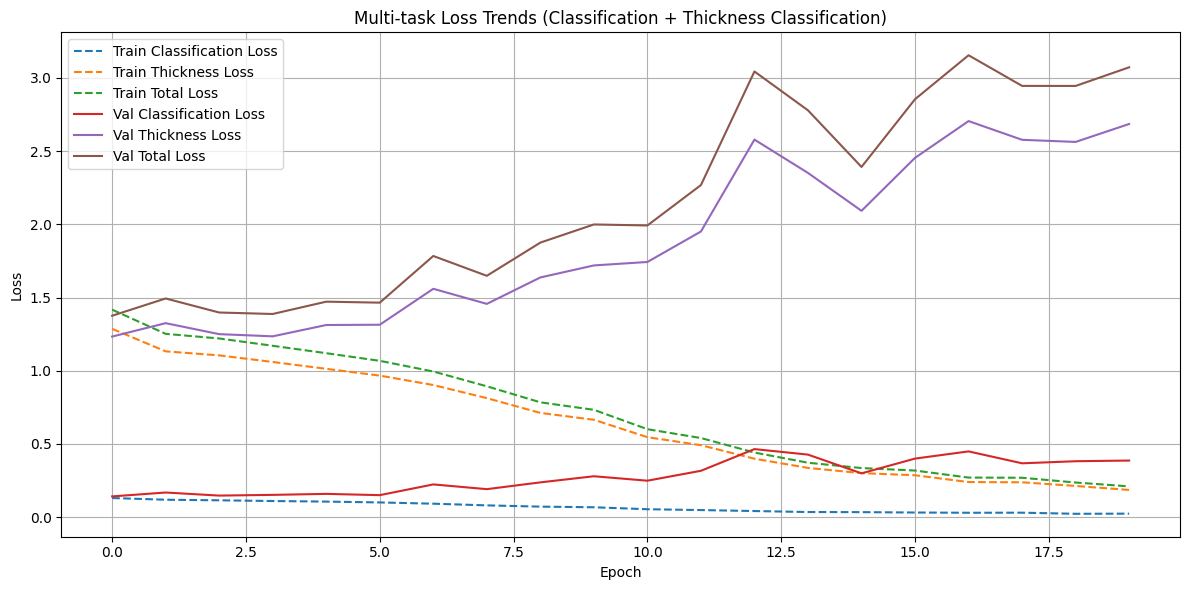

In [15]:
import json
import matplotlib.pyplot as plt

# JSON 불러오기
load_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_multitask_cls2_1e-4.json'

with open(load_path, 'r') as f:
    loss_history = json.load(f)

# 리스트로 추출 (thick으로 수정)
train_cls_losses = loss_history['train_cls_loss']
train_thick_losses = loss_history['train_thick_loss']
train_total_losses = loss_history['train_total_loss']
val_cls_losses = loss_history['val_cls_loss']
val_thick_losses = loss_history['val_thick_loss']
val_total_losses = loss_history['val_total_loss']

# 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_cls_losses, label='Train Classification Loss', linestyle='--')
plt.plot(train_thick_losses, label='Train Thickness Loss', linestyle='--')
plt.plot(train_total_losses, label='Train Total Loss', linestyle='--')

plt.plot(val_cls_losses, label='Val Classification Loss')
plt.plot(val_thick_losses, label='Val Thickness Loss')
plt.plot(val_total_losses, label='Val Total Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi-task Loss Trends (Classification + Thickness Classification)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### [11] 예측 수행

In [16]:
from tqdm import tqdm
import json
import torch

# 모델 로드
model = SiameseEfficientNetV2MultiTask().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/01unimodal/best_multitask_classification2.pth'))
model.eval()

# 예측 수행
results = []

with torch.no_grad():
    for left, right, labels, thickness_classes in tqdm(test_loader, desc="Predicting"):
        left, right = left.to(device), right.to(device)

        # 분류 + 두께 구간 분류 예측
        outputs_cls, outputs_thick_cls = model(left, right)

        probs_cls = torch.softmax(outputs_cls, dim=1)
        preds_cls = torch.argmax(probs_cls, dim=1)

        probs_thick = torch.softmax(outputs_thick_cls, dim=1)
        preds_thick = torch.argmax(probs_thick, dim=1)

        for true, pred, prob, true_thick, pred_thick in zip(
            labels.cpu(), preds_cls.cpu(), probs_cls[:, 1].cpu(),
            thickness_classes.cpu(), preds_thick.cpu()
        ):
            results.append({
                "true_label": int(true.item()),
                "pred_label": int(pred.item()),
                "prob_thickened": float(prob.item()),  # thickened 클래스 확률
                "true_thickness_class": int(true_thick.item()),
                "pred_thickness_class": int(pred_thick.item())
            })

# 결과 저장
output_path = "/content/drive/MyDrive/cv_project/01unimodal/predict_result_multitask_cls2_1e-4.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"예측 결과 저장 완료: {output_path}")


Predicting: 100%|██████████| 7/7 [01:35<00:00, 13.69s/it]

예측 결과 저장 완료: /content/drive/MyDrive/cv_project/01unimodal/predict_result_multitask_cls2_1e-4.json


[Classification Evaluation]
정확도 (Accuracy): 0.8000
AUC-ROC: 0.8856

분류 리포트:
              precision    recall  f1-score   support

      Normal       0.86      0.72      0.78        50
   Thickened       0.76      0.88      0.81        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

Confusion Matrix:
[[36 14]
 [ 6 44]]


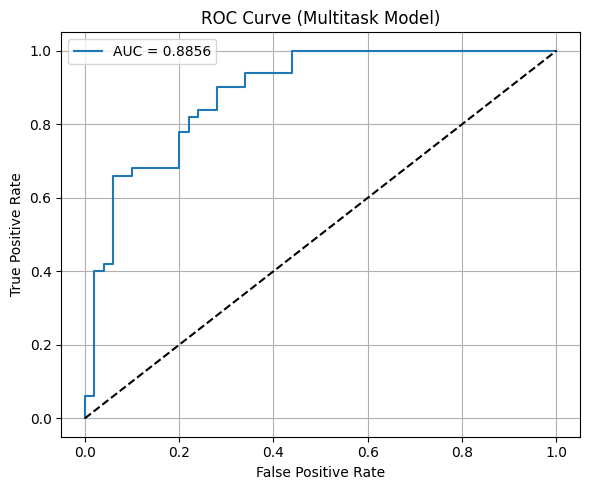


[Thickness Class Classification Evaluation]
정확도 (Accuracy): 0.5600
분류 리포트:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.67      0.78      0.72        45
           2       0.33      0.05      0.09        20
           3       0.44      0.77      0.56        26
           4       0.00      0.00      0.00         4

    accuracy                           0.56       100
   macro avg       0.29      0.32      0.27       100
weighted avg       0.49      0.56      0.49       100

Confusion Matrix:
[[ 0  5  0  0  0]
 [ 0 35  1  9  0]
 [ 0  7  1 12  0]
 [ 0  5  1 20  0]
 [ 0  0  0  4  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
import json
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score
)
import matplotlib.pyplot as plt

# 예측 결과 불러오기
with open("/content/drive/MyDrive/cv_project/01unimodal/predict_result_multitask_cls2_1e-4.json", "r") as f:
    results = json.load(f)

# 분류 관련 데이터
y_true = [r["true_label"] for r in results]
y_pred = [r["pred_label"] for r in results]
y_prob = [r["prob_thickened"] for r in results]

# 두께 구간 분류 관련 데이터
y_true_thick = [r["true_thickness_class"] for r in results]
y_pred_thick = [r["pred_thickness_class"] for r in results]

# === [Classification Evaluation] === #
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)
accuracy_cls = accuracy_score(y_true, y_pred)

print("[Classification Evaluation]")
print(f"정확도 (Accuracy): {accuracy_cls:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Thickened"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# === ROC Curve === #
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multitask Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === [Thickness Class Classification Evaluation] === #
accuracy_thick = accuracy_score(y_true_thick, y_pred_thick)

print("\n[Thickness Class Classification Evaluation]")
print(f"정확도 (Accuracy): {accuracy_thick:.4f}")
print("분류 리포트:")
print(classification_report(y_true_thick, y_pred_thick))
print("Confusion Matrix:")
print(confusion_matrix(y_true_thick, y_pred_thick))


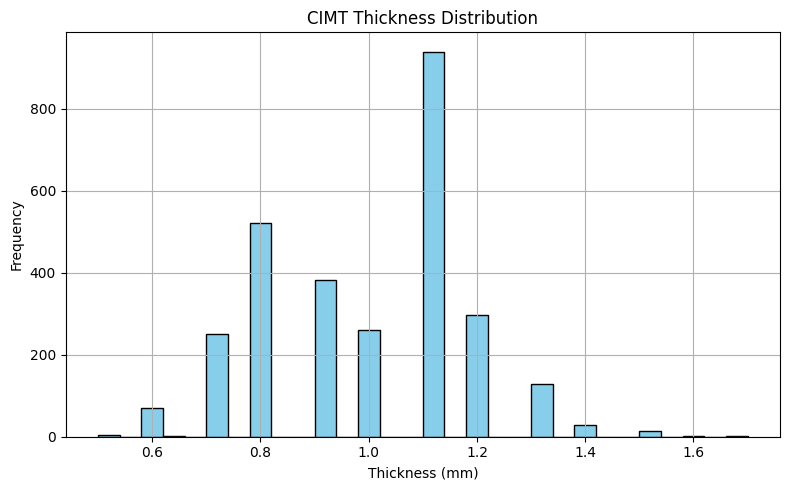

In [ ]:
import json
import matplotlib.pyplot as plt

# JSON 파일 경로
json_path = "/content/drive/MyDrive/cv_project/dataset/data_info.json"  # 경로에 맞게 수정해주세요

# JSON 데이터 불러오기
with open(json_path, 'r') as f:
    data = json.load(f)

# thickness 리스트 추출
thicknesses = [item["thickness"] for item in data.values()]

# 히스토그램 시각화
plt.figure(figsize=(8, 5))
plt.hist(thicknesses, bins=30, color='skyblue', edgecolor='black')
plt.title("CIMT Thickness Distribution")
plt.xlabel("Thickness (mm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


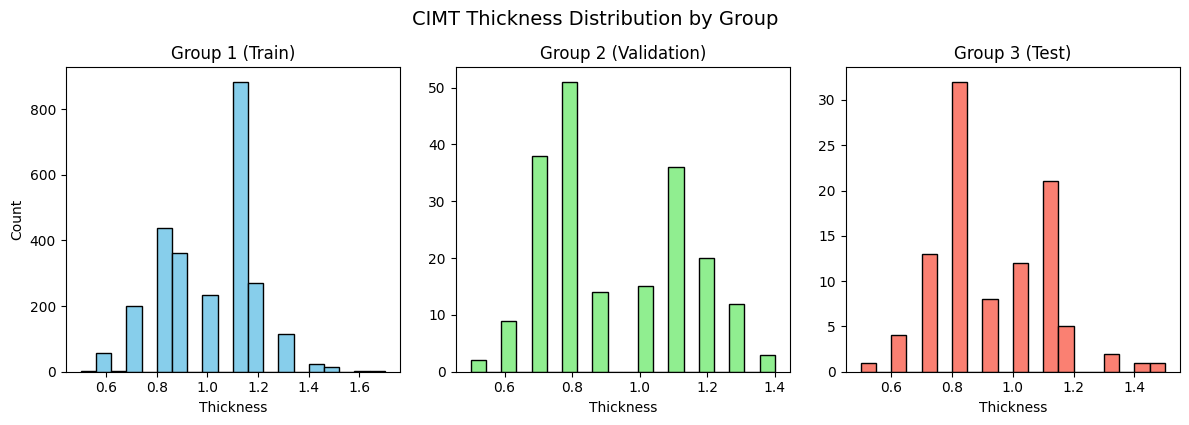

In [ ]:
import json
import matplotlib.pyplot as plt

# JSON 파일 경로
json_path = "/content/drive/MyDrive/cv_project/dataset/data_info.json"  # 경로는 필요시 수정

# JSON 데이터 불러오기
with open(json_path, 'r') as f:
    data = json.load(f)

# 그룹별 thickness 추출
group1 = [item["thickness"] for item in data.values() if item["group"] == 1]
group2 = [item["thickness"] for item in data.values() if item["group"] == 2]
group3 = [item["thickness"] for item in data.values() if item["group"] == 3]

# 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(group1, bins=20, color='skyblue', edgecolor='black')
plt.title("Group 1 (Train)")
plt.xlabel("Thickness")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
plt.hist(group2, bins=20, color='lightgreen', edgecolor='black')
plt.title("Group 2 (Validation)")
plt.xlabel("Thickness")

plt.subplot(1, 3, 3)
plt.hist(group3, bins=20, color='salmon', edgecolor='black')
plt.title("Group 3 (Test)")
plt.xlabel("Thickness")

plt.tight_layout()
plt.suptitle("CIMT Thickness Distribution by Group", fontsize=14, y=1.05)
plt.show()
